In [ ]:
!rm -rf *

In [ ]:
# Install dependencies
!pip install torch
!pip install ultralytics
!pip install pycocotools

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 870.5/870.5 kB 13.0 MB/s eta 0:00:00


In [ ]:
# Install wget if not already installed
!pip install wget

# Create directories for annotations
!mkdir -p /content/data

# Download COCO 2017 Annotations
!wget -P /content/data/ http://images.cocodataset.org/annotations/annotations_trainval2017.zip


  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=f9aa4c2bdc3a94a325b51fd9ee64473e8f187e73e2ebe6d6dc47b112e7792d99
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
--2024-10-15 15:15:24--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.12.53, 16.15.193.78, 16.182.68.161, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.12.53|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘/content/data/annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  10.8MB/s    in 25s     

2024-10-15 15:15:50 (9.61 MB/s) - ‘/content/data/annotations_trainval2017.zip’ saved [252907541/252907541]



In [ ]:
# Unzip the annotations
!unzip -q /content/data/annotations_trainval2017.zip -d /content/data/

In [ ]:
from pycocotools.coco import COCO
import random
import os
import urllib

# Load COCO annotations
coco = COCO('/content/data/annotations/instances_val2017.json')
person_category_id = coco.getCatIds(catNms=['person'])[0]

# Get all image IDs that contain 'person'
image_ids_with_person = coco.getImgIds(catIds=[person_category_id])

# Select 1000 random images that have the 'person' object
selected_image_ids = random.sample(image_ids_with_person, 1000)
selected_images = coco.loadImgs(selected_image_ids)

loading annotations into memory...
Done (t=0.57s)
creating index...
index created!


In [ ]:
os.makedirs('/content/data/images', exist_ok=True)

In [ ]:
# Download images based on annotations
for img in selected_images:
    image_url = f"http://images.cocodataset.org/val2017/{img['file_name']}"
    image_path = f"/content/data/images/{img['file_name']}"

    # Download image
    urllib.request.urlretrieve(image_url, image_path)

In [ ]:
# Create directories for labels
os.makedirs('data/labels', exist_ok=True)

for img in selected_images:
    # Save bounding box annotations in YOLO format
    ann_ids = coco.getAnnIds(imgIds=img['id'], catIds=[person_category_id])
    annotations = coco.loadAnns(ann_ids)
    label_file_path = f"data/labels/{img['file_name'].replace('.jpg', '.txt')}"

    img_width = img['width']
    img_height = img['height']

    with open(label_file_path, 'w') as f:
        for ann in annotations:
            if ann['category_id'] == person_category_id:
                x, y, w, h = ann['bbox']
                x_center = (x + w / 2) / img_width
                y_center = (y + h / 2) / img_height
                width = w / img_width
                height = h / img_height

                f.write(f"0 {x_center} {y_center} {width} {height}\n")

In [ ]:
import shutil
import math

# Create directories for train
os.makedirs('data/train/images', exist_ok=True)
os.makedirs('data/train/labels', exist_ok=True)

# Create directories for val
os.makedirs('data/val/images', exist_ok=True)
os.makedirs('data/val/labels', exist_ok=True)

# Create directories for val
os.makedirs('data/test/images', exist_ok=True)
os.makedirs('data/test/labels', exist_ok=True)

# Split data into training, validation and test
total_images = len(selected_images)
train_count = math.floor(0.8 * total_images)
val_count = math.floor(0.1 * total_images)
test_count = total_images - train_count - val_count

# Split images and labels into training, validation, and test sets
for img in selected_images[:train_count]:
    shutil.copyfile(f"/content/data/images/{img['file_name']}", f"data/train/images/{img['file_name']}")
    shutil.copyfile(f"data/labels/{img['file_name'].replace('.jpg', '.txt')}", f"data/train/labels/{img['file_name'].replace('.jpg', '.txt')}")

for img in selected_images[train_count:train_count + val_count]:
    shutil.copyfile(f"/content/data/images/{img['file_name']}", f"data/val/images/{img['file_name']}")
    shutil.copyfile(f"data/labels/{img['file_name'].replace('.jpg', '.txt')}", f"data/val/labels/{img['file_name'].replace('.jpg', '.txt')}")

for img in selected_images[train_count + val_count:]:
    shutil.copyfile(f"/content/data/images/{img['file_name']}", f"data/test/images/{img['file_name']}")
    shutil.copyfile(f"data/labels/{img['file_name'].replace('.jpg', '.txt')}", f"data/test/labels/{img['file_name'].replace('.jpg', '.txt')}")

In [ ]:
# Create YOLO config file (coco.yaml)
with open('coco.yaml', 'w') as f:
    f.write('path: /content/data\n')
    f.write('train: /content/data/train/images\n')
    f.write('val: /content/data/val/images\n')
    f.write('test: /content/data/test/images\n')
    f.write('nc: 1\n')  # Number of classes
    f.write("names: ['person']\n")  # Class names

In [ ]:
from ultralytics import YOLO
import torch

!rm -rf runs/
!yolo task=detect mode=train model=yolov8x.pt data=coco.yaml epochs=100

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
100% 131M/131M [00:02<00:00, 49.1MB/s]
Ultralytics 8.3.13 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=coco.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=

In [ ]:
!yolo task=detect mode=val model=runs/detect/train/weights/best.pt data=coco.yaml

Ultralytics 8.3.13 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 286 layers, 61,596,531 parameters, 0 gradients, 226.7 GFLOPs
val: Scanning /content/data/val/labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100% 100/100 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 7/7 [00:06<00:00,  1.12it/s]
                   all        100        419      0.624      0.569      0.588      0.354
Speed: 1.5ms preprocess, 48.5ms inference, 0.0ms loss, 7.3ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


In [ ]:
!yolo task=detect mode=predict model=runs/detect/train/weights/best.pt source="/content/data/images/000000057672.jpg" save=True conf=0.5

Ultralytics 8.3.13 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 286 layers, 61,596,531 parameters, 0 gradients, 226.7 GFLOPs

image 1/1 /content/data/images/000000057672.jpg: 480x640 11 persons, 84.1ms
Speed: 1.9ms preprocess, 84.1ms inference, 568.0ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


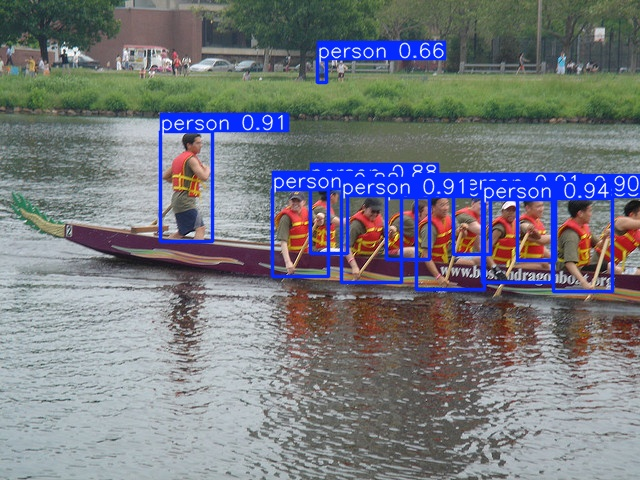

In [ ]:
from IPython.display import Image, display

predicted_image_path = '/content/runs/detect/predict/000000057672.jpg'

display(Image(filename=predicted_image_path))